In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os


import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.cuda.amp import GradScaler
from sklearn.metrics import accuracy_score
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
print(f"On device : {device}")

On device : cpu


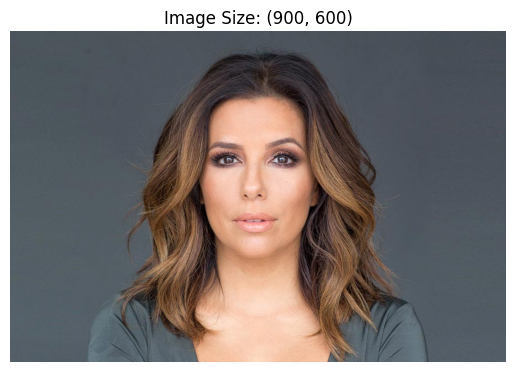

In [9]:
example_image_path = random.choice(os.listdir(r'C:\Users\Lenovo\Desktop\görüntü işleme\face shape detection\FaceShape Dataset\training_set\Oval'))
example_image_path = os.path.join(r"C:\Users\Lenovo\Desktop\görüntü işleme\face shape detection\FaceShape Dataset\training_set\Oval", example_image_path)
example_image = Image.open(example_image_path)

plt.imshow(example_image)
plt.title(f"Image Size: {example_image.size}")
plt.axis('off')
plt.show()

In [10]:
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [12]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count() - 1
TRAIN_PATH = r"C:\Users\Lenovo\Desktop\görüntü işleme\face shape detection\FaceShape Dataset\training_set"
TEST_PATH = r"C:\Users\Lenovo\Desktop\görüntü işleme\face shape detection\FaceShape Dataset\testing_set"

def safe_pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, SyntaxError):
        return Image.new('RGB', (224, 224))

train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transforms, loader=safe_pil_loader)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=test_transforms, loader=safe_pil_loader)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# num workers ları 0 yaptık
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [13]:
train_dataset.class_to_idx

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


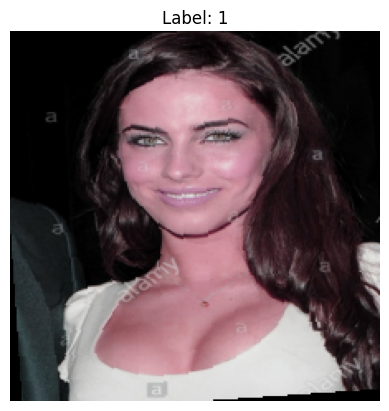

In [14]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

example_image = images[0]
example_image = example_image.permute(1, 2, 0).numpy()
example_label = labels[0].item()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
example_image = example_image * std + mean

plt.imshow(example_image)
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

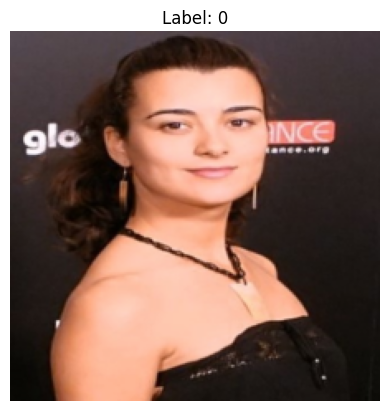

In [15]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

example_image = images[0]
example_image = example_image.permute(1, 2, 0).numpy()
example_label = labels[0].item()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
example_image = example_image * std + mean

plt.imshow(example_image)
plt.title(f"Label: {example_label}")
plt.axis('off')
plt.show()

In [16]:
# Use the updated weights parameter instead of pretrained
weights = torchvision.models.EfficientNet_B4_Weights.DEFAULT  # or IMAGENET1K_V1

model = models.efficientnet_b4(weights=weights)

num_classes = len(train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

model.to(device)
num_epochs = 30
best_val_loss = 1_000_000

In [17]:
# Güncellenmiş GradScaler kullanımı
scaler = torch.amp.GradScaler() if device == 'cuda' else None

for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Karma hassasiyet yalnızca CUDA kullanılabilir olduğunda çalıştırılır
        if device == 'cuda':
            with torch.autocast(device_type=device, dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = sum(train_losses) / len(train_losses)

    model.eval()
    validation_losses = []
    all_predictions = []
    all_labels = []

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_losses.append(loss)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_val_loss = sum(validation_losses) / len(validation_losses)
        scheduler.step(avg_val_loss)

        accuracy = accuracy_score(all_labels, all_predictions)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            os.makedirs('models', exist_ok=True)
            torch.save(model.state_dict(), 'models/best_model.pth')

print(f'Best Validation Loss: {best_val_loss:.4f}')


Epoch 1/30, Train Loss: 1.9288, Validation Loss: 1.5619, Accuracy: 0.2760
Epoch 2/30, Train Loss: 1.4223, Validation Loss: 1.3438, Accuracy: 0.4910
Epoch 3/30, Train Loss: 1.2638, Validation Loss: 1.2698, Accuracy: 0.5250
Epoch 4/30, Train Loss: 1.1254, Validation Loss: 1.1473, Accuracy: 0.6010
Epoch 5/30, Train Loss: 1.0289, Validation Loss: 1.1321, Accuracy: 0.6190
Epoch 6/30, Train Loss: 0.9314, Validation Loss: 1.1093, Accuracy: 0.6600
Epoch 7/30, Train Loss: 0.8547, Validation Loss: 1.0192, Accuracy: 0.7080
Epoch 8/30, Train Loss: 0.7877, Validation Loss: 1.1385, Accuracy: 0.6400
Epoch 9/30, Train Loss: 0.7418, Validation Loss: 0.9954, Accuracy: 0.7200
Epoch 10/30, Train Loss: 0.6970, Validation Loss: 0.9166, Accuracy: 0.7370
Epoch 11/30, Train Loss: 0.6455, Validation Loss: 1.0470, Accuracy: 0.7150
Epoch 12/30, Train Loss: 0.6540, Validation Loss: 0.9552, Accuracy: 0.7470
Epoch 13/30, Train Loss: 0.6130, Validation Loss: 0.9809, Accuracy: 0.7230
Epoch 14/30, Train Loss: 0.5943, V